In [ ]:
!pip install transformers

In [0]:
import tensorflow as tf
import torch

import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


from transformers import BertTokenizer as bertTokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

from sklearn.svm import SVC
from sklearn import preprocessing

from transformers import BertForSequenceClassification as bfsc,AdamW,BertConfig
from torch.utils.data import Dataset
from transformers import get_linear_schedule_with_warmup



Using TensorFlow backend.


In [0]:
gpuname=""
device=""
y=""
preprocessedTweets=""
ids_of_sentence=[]
ids_of_sentence_words=[]


In [0]:


gpuname=tf.test.gpu_device_name()
if gpuname=='/device:GPU:0':
  print('Found GPU at :{}'.format(gpuname))
else:
  gpuname=""
if torch.cuda.is_available():
  device=torch.device("cuda")
  n_gpu=torch.cuda.device_count()
  print("The device name is %s"%torch.cuda.get_device_name(0))
else:
  print("No GPU available using only CPU instead")
  device=torch.device("cpu")




Found GPU at :/device:GPU:0
The device name is Tesla P100-PCIE-16GB


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

def convertToFloat(val):
    if not val:
        return 0    
    try:
        return np.float64(val)
    except:        
        return np.float64(0)


headers=['id','text','average_ind','average_grp','average_oth','std_ind','std_grp','std_oth']
taskc = pd.read_csv("task_c_distant_ann.tsv", delimiter='\t',names=headers,low_memory=False,converters={"average_ind":convertToFloat,
                                                                                                    "average_grp":convertToFloat,
                                                                                                    "average_oth":convertToFloat,
                                                                                                    "std_ind":convertToFloat,
                                                                                                    "std_grp":convertToFloat,
                                                                                                    "std_oth":convertToFloat})
taskc=taskc[1:]

In [0]:
len(taskc)

188973

In [0]:
taskc.dtypes

id              object
text            object
average_ind    float64
average_grp    float64
average_oth    float64
std_ind        float64
std_grp        float64
std_oth        float64
dtype: object

In [0]:
#len(taskc)
#taskc=taskc[:10000]
#taska=taska[1000000:1500000]
#taska=taska[1500000:2500000]
#taska=taska[3500000:4500000]
#taska=taska[5500000:6500000]
#taska=taska[6000000:]

In [0]:

#GET THE DATA FROM THE PANDAS FRAME
headers=['id','tweet','subtask_a','subtask_b','subtask_c']
englishdata = pd.read_csv("/content/drive/My Drive/EnglishData/OLIDv1.0/olid-training-v1.0.tsv", delimiter='\t',names=headers,low_memory=False)
englishdata=englishdata[['id','tweet','subtask_c']]
englishdata=englishdata[1:]

In [0]:
englishdata = englishdata.dropna(subset=['subtask_c'])

In [0]:
len(englishdata)

3876

In [0]:
englishdata.head()

,id,tweet,subtask_c
2,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,IND
6,97670,@USER Liberals are all Kookoo !!!,OTH
8,52415,@USER was literally just talking about this lo...,GRP
10,13384,@USER Canada doesn’t need another CUCK! We alr...,IND
13,28414,@USER you are a lying corrupt traitor!!! Nobod...,IND


In [0]:
'''englishtrain,englishtest= train_test_split(englishdata, test_size=0.2, random_state=42)
export_csv = englishtrain.to_csv ('/content/drive/My Drive/EnglishData/olidlearn/TrainFileEnglish.tsv', index = None, header=True)
print (englishtrain.head())
#englishtest,englishpredict= train_test_split(englishtemp, test_size=0.5, random_state=42)
export_csv = englishtest.to_csv ('/content/drive/My Drive/EnglishData/olidlearn/TestFileEnglish.tsv', index = None, header=True)
print (englishtest.head())'''
#export_csv = englishpredict.to_csv ('/content/drive/My Drive/EnglishData/predictFileEnglish.csv', index = None, header=True)
#print (englishpredict.head())

"englishtrain,englishtest= train_test_split(englishdata, test_size=0.2, random_state=42)\nexport_csv = englishtrain.to_csv ('/content/drive/My Drive/EnglishData/olidlearn/TrainFileEnglish.tsv', index = None, header=True)\nprint (englishtrain.head())\n#englishtest,englishpredict= train_test_split(englishtemp, test_size=0.5, random_state=42)\nexport_csv = englishtest.to_csv ('/content/drive/My Drive/EnglishData/olidlearn/TestFileEnglish.tsv', index = None, header=True)\nprint (englishtest.head())"

In [0]:
ids_of_sentence=[]
ids_of_sentence_words=[]
attention_masks=[]

def giveIds(sentence):
  maxlength=0
  tokenizer=bertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
  for t in sentence:
      tokenized_sentence_id=tokenizer.encode(t,add_special_tokens=True)
      if(maxlength<len(tokenized_sentence_id)):
          maxlength=len(tokenized_sentence_id)
  return maxlength

In [0]:
dfnumpy=taskc.to_numpy()
x_train=dfnumpy[:, 1].reshape(-1, 1)
y_train=dfnumpy[:, 2].reshape(-1, 1)

In [0]:
type(y_train)

numpy.ndarray

In [0]:

def giveLabel(y1,y2,y3):
  i=0
  largest_index=0
  #label1=['IND','GRP','OTH']
  ylabels=[]
  for r in y1:
    if (y1[i] >= y2[i]) and (y1[i] >= y3[i]): 
        largest_index = 0 
    elif (y2[i] >= y1[i]) and (y2[i] >= y3[i]): 
        largest_index = 1 
    else: 
        largest_index = 2 
    
    ylabels.append(largest_index)
    i=i+1;
  return ylabels

dfnumpy=taskc.to_numpy();
x_train=dfnumpy[:, 1].reshape(-1, 1)
y_train1=dfnumpy[:, 2].reshape(-1, 1)
y_train2=dfnumpy[:, 3].reshape(-1, 1)
y_train3=dfnumpy[:, 4].reshape(-1, 1)


In [0]:
y1=giveLabel(y_train1,y_train2,y_train3)

In [0]:
dfnumpy=englishdata.to_numpy()
x_test=dfnumpy[:, 1].reshape(-1, 1)
y_test=dfnumpy[:, 2].reshape(-1, 1)

In [0]:
len(x_test)

3876

In [0]:
print(y1.count(0))
print(y1.count(1))
print(y1.count(2))


152562
24917
11494


In [0]:
print(y1.count(0)/len(y1))
print(y1.count(1)/len(y1))
print(y1.count(2)/len(y1))
['IND','GRP','OTH']

0.8073216808750456
0.1318548152381557
0.06082350388679864


['IND', 'GRP', 'OTH']

In [0]:
from sklearn.utils import shuffle
x_train,y_train=shuffle(x_train,y1)

In [0]:

def giveLabel2(y1):
  i=0
  largest_index=0
  #label1=['IND','GRP','OTH']
  ylabels=[]
  for r in y1:
    if (r=="IND"): 
        largest_index = 0 
    elif (r=="GRP"):
        largest_index = 1 
    else: 
        largest_index = 2 
    
    ylabels.append(largest_index)
    i=i+1;
  return ylabels

In [0]:
from sklearn.svm import SVC
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
#print(y_train.shape)
print(y_test.shape)
#print(y_predict.shape)
yTrain=le.fit_transform(y_train)
print(yTrain.shape)
print(le.classes_)
#le.fit_transform(['IND','GRP','OTH'])
yl=giveLabel2(y_test.flatten())
yTest=le.fit_transform(y1)
print(le.classes_)


(3876, 1)
(188973,)
[0 1 2]
[0 1 2]


In [0]:
yTest.flatten().tolist().count(2)

11494

In [0]:
###IMPORTANT
'''xtest,x_test_mask=giveIds(x_test.flatten(),y_test)
x_test_pytorch=torch.tensor(xtest)
y_test_pytorch=torch.tensor(y_test)
x_test_mask_pytorch=torch.tensor(x_test_mask)
tedata=TensorDataset(x_test_pytorch,x_test_mask_pytorch,y_test_pytorch)
tesampler=RandomSampler(tedata)
bsize=64
tedataloader=DataLoader(tedata,sampler=tesampler,batch_size=bsize)
print(len(xtest))
print(len(y_test))
len(x_train)
'''

'xtest,x_test_mask=giveIds(x_test.flatten(),y_test)\nx_test_pytorch=torch.tensor(xtest)\ny_test_pytorch=torch.tensor(y_test)\nx_test_mask_pytorch=torch.tensor(x_test_mask)\ntedata=TensorDataset(x_test_pytorch,x_test_mask_pytorch,y_test_pytorch)\ntesampler=RandomSampler(tedata)\nbsize=64\ntedataloader=DataLoader(tedata,sampler=tesampler,batch_size=bsize)\nprint(len(xtest))\nprint(len(y_test))\nlen(x_train)\n'

In [0]:
from transformers import BertForSequenceClassification as bfsc,AdamW,BertConfig
model=bfsc.from_pretrained('bert-base-uncased',num_labels=3,output_attentions=False,output_hidden_states=False)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
##ONLY FOR THE FIRST TIME SAVE ELSE LOAD
#torch.save({'state_dict': model.state_dict()}, '/content/drive/My Drive/EnglishData/BERTNEWsubtaskc.pth.tar')
checkpoint = torch.load('/content/drive/My Drive/EnglishData/SUBTASKC1/2/BERTNEWsubtaskc.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
  

<All keys matched successfully>

In [0]:
params=list(model.named_parameters())

In [0]:
no_decay = ["bias", "beta","LayerNorm.weight","gamma"]
optimizer_grouped_parameters = [
{
"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
"weight_decay": 0.01,
},
{"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]

In [0]:
optimizer=AdamW(model.parameters(),lr=2e-5,eps=1e-8)

In [0]:
data = pd.DataFrame()
data['predicted']=['X']
data['true']=['X']
data.to_csv('/content/drive/My Drive/EnglishData/SUBTASKC1/2/OLIDSUBTASKCBERT.csv') 


In [0]:
MAXLENGTH=64

In [0]:
class EnglishTrainDataset(Dataset):
    def __init__(self,xytrain):
        self.xytrain = xytrain
        self.maxlength=MAXLENGTH
       
    def __getitem__(self, index):
        tokenized_review = tokenizer.tokenize(str(self.xytrain[0][index].flatten()))
        if len(tokenized_review) > self.maxlength:
            #print(tokenized_review)
            tokenized_review = tokenized_review[:self.maxlength]
        
        
        ids_of_sentence_word  = tokenizer.convert_tokens_to_ids(tokenized_review)
        padding = [0] * (self.maxlength - len(ids_of_sentence_word))
        ids_of_sentence_word += padding
        assert len(ids_of_sentence_word) == self.maxlength
        #print(ids_of_sentence_word)
        attention_mask = [int(b > 0) for b in ids_of_sentence_word] 
        x_train_pytorch = torch.tensor(ids_of_sentence_word)
        y_train_pytorch=torch.tensor(self.xytrain[1][index])
        x_train_mask_pytorch=torch.tensor(attention_mask)
        
        return x_train_pytorch,x_train_mask_pytorch,y_train_pytorch
        #return [1,2,3]
        
    def __len__(self):
        return len(self.xytrain[0])
 

'\nz=0;\nfor batch_idx, data in enumerate(tdataloader): \n  if z==100:\n    break;\n  z=z+1;'

In [0]:
class EnglishTestDataset(Dataset):
    def __init__(self,xytest):
        self.xytest = xytest
        self.maxlength=MAXLENGTH
       
    def __getitem__(self, index):
        tokenized_review = tokenizer.tokenize(str(self.xytest[0][index].flatten()))
        if len(tokenized_review) > self.maxlength:
            #print(tokenized_review)
            tokenized_review = tokenized_review[:self.maxlength]
        
        
        ids_of_sentence_word  = tokenizer.convert_tokens_to_ids(tokenized_review)
        padding = [0] * (self.maxlength - len(ids_of_sentence_word))
        ids_of_sentence_word += padding
        assert len(ids_of_sentence_word) == self.maxlength
        #print(ids_of_sentence_word)
        attention_mask = [int(b > 0) for b in ids_of_sentence_word] 
        x_test_pytorch = torch.tensor(ids_of_sentence_word)
        y_test_pytorch=torch.tensor(self.xytest[1][index])
        x_test_mask_pytorch=torch.tensor(attention_mask)
        
        return x_test_pytorch,x_test_mask_pytorch,y_test_pytorch
        #return [1,2,3]
        
    def __len__(self):
        return len(self.xytest[0])



In [0]:
MAXLENGTH=64
xytrain=[x_train,yTrain]
tokenizer=bertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
tdataset = EnglishTrainDataset(xytrain)
tsampler=RandomSampler(tdataset)
tdataloader = DataLoader(tdataset, batch_size=32, num_workers=1, shuffle=False,sampler=tsampler)

In [0]:
xytest=[x_test,yTest]
tokenizer=bertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
tedataset = EnglishTestDataset(xytest) 
tesampler=RandomSampler(tedataset)
tedataloader = DataLoader(tedataset, batch_size=32, num_workers=1, shuffle=False,sampler=tesampler)

In [0]:
len(xytrain[0])

188973

In [ ]:
epochs=4
total_steps=len(tdataloader)*epochs
sch=get_linear_schedule_with_warmup(optimizer,
                                    num_warmup_steps=0,num_training_steps=total_steps)

## Training Code Below

In [ ]:
import random
import time 

def set_seed(seed,ngpu):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if ngpu > 0:
        torch.cuda.manual_seed_all(seed)
      
set_seed(42,torch.cuda.device_count())
#remove later
keeptrack=0
epochs=4
lossList=[]
max_grad_norm=1.0
for e in range(0, epochs):
    
    print("Start Epoch Number",(e + 1))
    print("Start Training")
    if device.type=="cpu":
     model.to(device)
     map_location='cpu'
    else:
      model.cuda()
      map_location=lambda storage, loc: storage.cuda()
    checkpoint = torch.load('/content/drive/My Drive/EnglishData/BERTNEWsubtaskc.pth.tar',map_location=map_location)
    model.load_state_dict(checkpoint['state_dict'])

    #Amount of time taken for training
    t1 = time.time()
    tr_loss, logging_loss = 0.0, 0.0
    model.train()
    tsteps=0
    for step, batch in enumerate(tdataloader):
        if step % 50 == 0 and not step == 0:
            print("Batch Completed  {:,}  of  {:,}.    Elapsed time is  {}".format(step, len(tdataloader),time.time() - t1))
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        model.zero_grad()

        outputs = model(inputs["input_ids"],token_type_ids=None,attention_mask=inputs["attention_mask"], labels=inputs["labels"])
        loss = outputs[0]
        loss.backward()
        tr_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        tsteps+=1
        optimizer.step()
        sch.step()
    a_tr_loss = tr_loss /(tsteps)               
    lossList.append(a_tr_loss)
    print(" The training loss incured is  {0:.3f}".format(a_tr_loss))
    t2=time.time()
    print("  Training one epoch time taken",t2-t1)
    print(" Validation starts here ")
    t1 = time.time()
    model.eval()
    eval_loss = 0
    nb_eval_steps = 0
    eval_f1=0
    eval_acc=0
    
    for batch_idx, data in enumerate(tedataloader):
        
        batch = tuple(t.to(device) for t in data)            
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        with torch.no_grad():        
           outputs = model(inputs["input_ids"],token_type_ids=None,attention_mask=inputs["attention_mask"])
        logits = outputs[0]
        print(keeptrack)
        keeptrack+=32
        logits = logits.detach().cpu().numpy()
        label_ids = (inputs["labels"]).to('cpu').numpy()
        tmpf1score,tmpaccscore = calculateF1Score(logits, label_ids)
        eval_f1 = eval_f1+tmpf1score
        eval_acc=eval_acc+tmpaccscore
        nb_eval_steps += 1
        #print(" TEMP F1 score: {0:.3f}".format(tmpf1score))
        #print("TEMP  Accuracy score: {0:.3f}".format(tmpaccscore))
    torch.save({'state_dict': model.state_dict()}, '/content/drive/My Drive/EnglishData/BERTNEWsubtaskc.pth.tar')
    print("  F1 score: {0:.3f}".format(eval_f1/nb_eval_steps))
    print("  Accuracy score: {0:.3f}".format(eval_acc/nb_eval_steps))
    t2=time.time()
    print("  Validating one epoch time taken ",t2-t1)
      
print("ALL DONE!!!")

## If model already present use below 

In [ ]:
#OLID Datasets

In [0]:
##F1 score calculate and store
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculateF1Score(predictions,labels):
  #rowwise return the index of the max element ie 0 or 1 depending on the maximum value returned
  predictionArgmax=np.argmax(predictions,axis=1).flatten()
  labelsFlattend=labels.flatten()
  print("Predictions Argmax",predictionArgmax)
  print("labels Flattened",labelsFlattend)
  data=pd.read_csv('/content/drive/My Drive/EnglishData/SUBTASKC1/2/OLIDSUBTASKCBERT.csv')#,converters={'predicted': eval,'true': eval})
  ypred=data['predicted'].to_numpy().tolist()
  for t in predictionArgmax:
    ypred.append(t)

  print(len(ypred))
  ytrue=data['true'].to_numpy().tolist()
  for t in labelsFlattend:
    ytrue.append(t)
  data = pd.DataFrame()
  data['predicted']=ypred
  data['true']=ytrue
  data.to_csv('/content/drive/My Drive/EnglishData/SUBTASKC1/2/OLIDSUBTASKCBERT.csv') 

  return f1_score(labelsFlattend, predictionArgmax, average='macro'),accuracy_score(labelsFlattend, predictionArgmax)



In [0]:
import random
import time 

def set_seed(seed,ngpu):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if ngpu > 0:
        torch.cuda.manual_seed_all(seed)
      
set_seed(42,torch.cuda.device_count())
#remove later

epochs=4
lossList=[]
if device.type=="cpu":
     model.to(device)
     map_location='cpu'
else:
      model.cuda()
      map_location=lambda storage, loc: storage.cuda()
checkpoint = torch.load('/content/drive/My Drive/EnglishData/SUBTASKC1/2/BERTNEWsubtaskc.pth.tar',map_location=map_location)
model.load_state_dict(checkpoint['state_dict'])
max_grad_norm=1.0
t1 = time.time()
model.eval()
eval_loss = 0
nb_eval_steps = 0
eval_f1=0
eval_acc=0
 
for batch_idx, data in enumerate(tedataloader):
        
      batch = tuple(t.to(device) for t in data)            
      inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
      with torch.no_grad():        
         outputs = model(inputs["input_ids"],token_type_ids=None,attention_mask=inputs["attention_mask"])
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      label_ids = (inputs["labels"]).to('cpu').numpy()
      tmpf1score,tmpaccscore = calculateF1Score(logits, label_ids)
      eval_f1 = eval_f1+tmpf1score
      eval_acc=eval_acc+tmpaccscore
      nb_eval_steps += 1
      #print(" TEMP F1 score: {0:.3f}".format(tmpf1score))
      #print("TEMP  Accuracy score: {0:.3f}".format(tmpaccscore))
print("  F1 score: {0:.3f}".format(eval_f1/nb_eval_steps))
print("  Accuracy score: {0:.3f}".format(eval_acc/nb_eval_steps))
t2=time.time()
print("  Validating one epoch time taken ",t2-t1)

Predictions Argmax [0 1 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 1 2 2 0 0 0 2 0 0 0 1 1]
labels Flattened [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0]
33
Predictions Argmax [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 2 1 1 1 0 1 1 2 0 1 1 0 0 0 1 0 1]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 2 0 1 0 0]
65
Predictions Argmax [0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 2 0 0 1 0 0 0 0]
labels Flattened [1 0 2 0 1 2 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
97
Predictions Argmax [0 1 0 0 1 0 0 0 0 1 0 2 1 0 1 2 2 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1]
labels Flattened [0 0 2 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 2]
129
Predictions Argmax [1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0]
labels Flattened [1 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 2 0 0 0 0]
161
Predictions Argmax [0 0 2 0 1 2 1 0 0 1 2 1 0 0 0 1 1 0 2 2 1 0 0 1 0 0 0 1 0 0 0 1]
labels Flattened [0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 

In [ ]:
def toLabels(i):
  if i=='0':
    return 'IND'
  elif i =='1':
    return 'GRP'
  else:
    return 'OTH'

tweetsOLID=englishdata[['id','tweet']]
print(len(tweetsOLID))
dfnumpy=tweetsOLID.to_numpy()
TWEETS1=dfnumpy[:, 1].reshape(-1, 1).tolist()
teets=np.squeeze(TWEETS1).tolist()
print(teets)
print(len(TWEETS1))
data=pd.read_csv('/content/drive/My Drive/EnglishData/SUBTASKC1/2/OLIDSUBTASKCBERT.csv')
ypred=data['predicted'].to_numpy().tolist()
len(ypred)
ypred=ypred[1:]
ypred=[toLabels(i) for i in ypred]
#ypred=[ypred[i].flatten().tolist() for i in range(len(ypred))]
print(ypred)
print(len(ypred))
ytrue=data['true'].to_numpy().tolist()
ytrue=ytrue[1:]
ytrue=[toLabels(i) for i in ytrue]
#ytrue=[ytrue[i].flatten().tolist() for i in range(len(ytrue))]

print(ytrue)
print(len(ytrue))

data = pd.DataFrame()
data['tweets']=teets
data['predicted']=ypred
data['true']=ytrue
data.to_csv('/content/drive/My Drive/EnglishData/SUBTASKC1/2/OLIDSUBTASKCBERT.csv') 


In [ ]:
from sklearn.metrics import confusion_matrix
cnf=confusion_matrix(ytrue, ypred, labels=['IND', 'GRP', 'OTH'])
print(cnf)

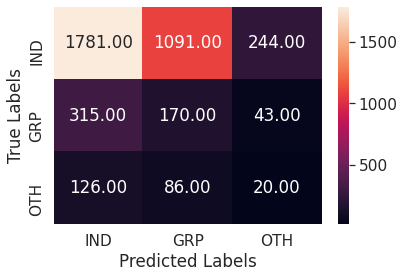

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cnf,['IND', 'GRP', 'OTH'], ['IND', 'GRP', 'OTH'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='.2f') # font size
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()

# ALL ind baseline result

In [0]:
ygiven=[]
ypredicted=[]

In [0]:
data = pd.DataFrame()
data['predicted']=['X']
data['true']=['X']
data.to_csv('/content/drive/My Drive/EnglishData/SUBTASKC1/2/BASELINESUBTASKCBERT.csv') 


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculateF1Score(predictions,labels):
  #rowwise return the index of the max element ie 0 or 1 depending on the maximum value returned
  predictionArgmax=np.argmax(predictions,axis=1).flatten()
  labelsFlattend=labels.flatten()
  print("Predictions Argmax",predictionArgmax)
  print("labels Flattened",labelsFlattend)
  data=pd.read_csv('/content/drive/My Drive/EnglishData/SUBTASKC1/2/BASELINESUBTASKCBERT.csv')#,converters={'predicted': eval,'true': eval})
  ypred=data['predicted'].to_numpy().tolist()
  for t in predictionArgmax:
    ypred.append(t)

  print(len(ypred))
  ytrue=data['true'].to_numpy().tolist()
  for t in labelsFlattend:
    ytrue.append(t)
  data = pd.DataFrame()
  data['predicted']=ypred
  data['true']=ytrue
  data.to_csv('/content/drive/My Drive/EnglishData/SUBTASKC1/2/BASELINESUBTASKCBERT.csv') 

  return f1_score(labelsFlattend, predictionArgmax, average='macro'),accuracy_score(labelsFlattend, predictionArgmax)



In [0]:
def readData1():
  headers=['id','ypredicted']
  greekdataBaseline = pd.read_csv("test_c_baseline.csv", delimiter=',',names=headers)
  #,converters={"id":convertToInt}       
  #greekdataBaseline.id = greekdataBaseline.id.astype(int)
  #greekdataBaseline=greekdataBaseline[1:]
  print(greekdataBaseline.head())
  print(greekdataBaseline.shape)

  headers=['id','tweet']
  greekDataTest = pd.read_csv("test_c_tweets.tsv", delimiter='\t',names=headers)
                                #converters={"id":convertToInt})
  #greekDataTest=greekDataTest[1:]
  print(greekDataTest.head())
  #print(greekDataTest.dtypes)
  print(greekDataTest.shape)
  result = pd.merge(greekDataTest, greekdataBaseline, on='id', how='inner')
  print(result.head())
  print(result.dtypes)
  print(result.shape)

  #result=
  #result.sort_values(by=['id'], inplace=True)
  #print(result.head())
  dfnumpy=result.to_numpy();
  X=dfnumpy[:, 1].reshape(-1, 1)
  y=dfnumpy[:, 2].reshape(-1, 1)
  tid=dfnumpy[:, 0].reshape(-1, 1)
  preprocessedTweets=X[:,0]
  return preprocessedTweets,y,tid

In [0]:
preprocessedTweets,y,tid=readData1()

     id ypredicted
0   BC0        IND
1   BC3        IND
2   BC9        IND
3  BC10        IND
4  BC19        IND
(850, 2)
     id                                              tweet
0    id                                              tweet
1   BC0  @USER Lmao bihhh dis what u do to your homies ...
2   BC3  @USER The POTUS is a racist, racist, racist, r...
3   BC9  @USER He then grinned, raising his brow.  Oh d...
4  BC10         Niggas priorities be fucked all the way up
(851, 2)
     id                                              tweet ypredicted
0   BC0  @USER Lmao bihhh dis what u do to your homies ...        IND
1   BC3  @USER The POTUS is a racist, racist, racist, r...        IND
2   BC9  @USER He then grinned, raising his brow.  Oh d...        IND
3  BC10         Niggas priorities be fucked all the way up        IND
4  BC19  You bitches really be walking around talking s...        IND
id            object
tweet         object
ypredicted    object
dtype: object
(850, 3)


In [0]:
ftid=[]
for t in tid.flatten().tolist():
  ftid.append(int(t.split("BC")[1]))

In [0]:
from torch.utils.data import Dataset
tokenizer=bertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
class GreekPredictDataset(Dataset):
    def __init__(self,xypredict):
        self.xypredict = xypredict
        self.maxlength=128
       
    def __getitem__(self, index):
        tokenized_review = tokenizer.tokenize(str(self.xypredict[0][index]))
        if len(tokenized_review) > self.maxlength:
            #print(tokenized_review)
            tokenized_review = tokenized_review[:self.maxlength]
        
        
        ids_of_sentence_word  = tokenizer.convert_tokens_to_ids(tokenized_review)
        padding = [0] * (self.maxlength - len(ids_of_sentence_word))
        ids_of_sentence_word += padding
        assert len(ids_of_sentence_word) == self.maxlength
        #print(ids_of_sentence_word)
        attention_mask = [int(b > 0) for b in ids_of_sentence_word] 
        x_predict_pytorch = torch.tensor(ids_of_sentence_word)
        y_predict_pytorch=torch.tensor(self.xypredict[1][index])
        x_predict_mask_pytorch=torch.tensor(attention_mask)
        tid_predict_pytorch=torch.tensor(self.xypredict[2][index])
        
        return x_predict_pytorch,x_predict_mask_pytorch,y_predict_pytorch,tid_predict_pytorch
       
    def __len__(self):
        return len(self.xypredict[0])
 
 
 

In [0]:
yres=[]
finalTid=[]
def predictingData(pTweets,ypred,tid):
  ids_of_sentence=[]
  predictedLabels,trueLabels=[],[]
  
  le = preprocessing.LabelEncoder()
  ypredict=le.fit_transform(ypred.flatten())
  map_location=""
  xypredict=[pTweets,ypredict,tid]
  
  tdataset = GreekPredictDataset(xypredict)
  tsampler=RandomSampler(tdataset)
  predictdataloader = DataLoader(tdataset, batch_size=32, num_workers=1, shuffle=False,sampler=tsampler)
  print(device.type)
  model=bfsc.from_pretrained('bert-base-uncased',num_labels=3,output_attentions=False,output_hidden_states=False)
  if device.type=="cpu":
    model.to(device)
    map_location='cpu'
  else:
    model.cuda()
    map_location=lambda storage, loc: storage.cuda()
  params=list(model.named_parameters())
  eval_f1=0
  eval_acc=0
  nb_eval_steps=0
  checkpoint = torch.load('/content/drive/My Drive/EnglishData/SUBTASKC1/2/BERTNEWsubtaskc.pth.tar',map_location=map_location)
  model.load_state_dict(checkpoint['state_dict'])
  model.eval()
  i=0
  for batch in predictdataloader:
      print(i)
      i=i+1
      batch = tuple(t.to(device) for t in batch)        
      inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2],"tids":batch[3]}
      
      with torch.no_grad():       
          outputs = model(inputs["input_ids"],token_type_ids=None,attention_mask=inputs["attention_mask"])
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      label_ids = (inputs["labels"]).to('cpu').numpy()
      predictedLabels.append(logits)
      trueLabels.append(label_ids)
      tidl=(inputs["tids"]).to('cpu').numpy()
      finalTid.append(tidl)
      tmpf1score,tmpaccscore = calculateF1Score(logits, label_ids)
      eval_f1 = eval_f1+tmpf1score
      eval_acc=eval_acc+tmpaccscore
      nb_eval_steps += 1
      
  print("  F1 score: {0:.3f}".format(eval_f1/nb_eval_steps))
  print("  Accuracy score: {0:.3f}".format(eval_acc/nb_eval_steps))
  return predictedLabels,trueLabels,finalTid

In [0]:
#gpuname,device=initGpus1()  
preprocessedTweets,y,tid=readData1()


     id ypredicted
0   BC0        IND
1   BC3        IND
2   BC9        IND
3  BC10        IND
4  BC19        IND
(850, 2)
     id                                              tweet
0    id                                              tweet
1   BC0  @USER Lmao bihhh dis what u do to your homies ...
2   BC3  @USER The POTUS is a racist, racist, racist, r...
3   BC9  @USER He then grinned, raising his brow.  Oh d...
4  BC10         Niggas priorities be fucked all the way up
(851, 2)
     id                                              tweet ypredicted
0   BC0  @USER Lmao bihhh dis what u do to your homies ...        IND
1   BC3  @USER The POTUS is a racist, racist, racist, r...        IND
2   BC9  @USER He then grinned, raising his brow.  Oh d...        IND
3  BC10         Niggas priorities be fucked all the way up        IND
4  BC19  You bitches really be walking around talking s...        IND
id            object
tweet         object
ypredicted    object
dtype: object
(850, 3)


In [0]:
ftid=[]
for t in tid.flatten().tolist():
  ftid.append(int(t.split("BC")[1]))

In [0]:
tid=ftid

In [0]:
set(y.flatten())

{'IND'}

## RESULT ON all IND baseline

In [0]:
predictedLabels,trueLabels,finalTid=predictingData(preprocessedTweets,y,tid)

cuda
0
Predictions Argmax [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33
1
Predictions Argmax [0 0 1 0 0 1 0 1 2 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65
2
Predictions Argmax [0 0 2 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97
3
Predictions Argmax [1 1 1 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 1 0]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
129
4
Predictions Argmax [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
161
5
Predictions Argmax [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 0

In [0]:
yans=[yres[i].flatten().tolist() for i in range(len(yres))]
ytrue=[trueLabels[i].flatten().tolist() for i in range(len(trueLabels))]
ytid=[finalTid[i].flatten().tolist() for i in range(len(finalTid))]

In [0]:
from itertools import chain

yans=list(chain.from_iterable(yans))

ytrue=list(chain.from_iterable(ytrue))

ytid=list(chain.from_iterable(ytid))

In [0]:
len(yans)

850

In [0]:
ytid2=["BC"+str(t) for t in ytid]

In [0]:
len(ytid2)

In [0]:
yans1=[]

In [0]:
yans3=[]

In [0]:
yans1=[]
for i in range(len(yans)):
  if yans[i]==0:
    yans3.append("IND")
  elif yans[i]==1:
    yans3.append("GRP")
  else:
    yans3.append("OTH")


In [0]:
ytrue3 = []

In [0]:
for i in range(len(ytrue)):
  if ytrue[i]==0:
    ytrue3.append("IND")
  elif ytrue[i]==1:
    ytrue3.append("GRP")
  else:
    ytrue3.append("OTH")


In [0]:
print(yans3.count("IND"))
print(yans3.count("GRP"))
print(yans3.count("OTH"))


In [0]:
len(yans3)

In [0]:
print(ytrue3.count("IND"))
print(ytrue3.count("GRP"))
print(ytrue3.count("OTH"))
